In [ ]:
pip install fasttext

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, f1_score, confusion_matrix
import os
import pandas as pd
import joblib
import numpy as np
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import fasttext.util
import itertools
from collections import Counter
from openpyxl import load_workbook
from scipy.stats import kendalltau
import seaborn as sns

#fasttext.util.download_model('nl', if_exists='ignore')  # English
#ft = fasttext.load_model('cc.nl.300.bin')
#ft.get_dimension()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
  ID and information about all pre-processed datasets
'''
# # 1 == Original pre processing # removed stop words - heuristic duplicate removal - low word count row removal
# # 2 == Second pre processing - heuristic duplicate removal - low word count row removal
# # 3 == Second pre processing - ALL duplicate removal - low word count row removal
# # 4 == Second pre processing - NO duplicate removal - low word count row removal (NOT SURE IF WORD COUNT REMOVAL WAS DONE ON THIS DATA SET)
# # 5 == Second pre processing - Lemmatization
# # 6 == Second pre processing - Stemming
# # 7 == Original pre processing - Stemming
# # 8 == Original pre processing - Lemmatization
# # 9 == Second pre processing - ngrams

'\n  ID and information about all pre-processed datasets \n'

In [ ]:
def main(settings_to_run):
  '''main function
  Args:
      settings_to_run (list): List containing all settings to run
  Returns:
      None
  '''
  # All settings we want to test for raportation
  base_folder = settings_to_run[0]
  try:
    os.mkdir(base_folder)
  except FileExistsError:
    pass
  results_folder = settings_to_run[1]
  try:
    os.mkdir(results_folder)
    print(results_folder, 'made')
  except FileExistsError:
    pass
  results_file = settings_to_run[2]
  if not os.path.exists(results_file):
    temp_df = pd.DataFrame()
    temp_df.to_excel(results_file, index=False)

  # 6660 for downsampling data based on first number, 100000000 - no downsampling
  max_instances_options = settings_to_run[3]
  random_state_values = settings_to_run[4]
  tf_idf_max_features_options = settings_to_run[5]
  iterations_max_options = settings_to_run[6]
  use_class_weighting_options = settings_to_run[7]
  use_embeddings_options = settings_to_run[8]
  pre_selected_use_directory_options = settings_to_run[9]
  # create combinations
  all_combinations = itertools.product(
      max_instances_options, random_state_values, tf_idf_max_features_options,
      iterations_max_options, use_class_weighting_options, use_embeddings_options,
      pre_selected_use_directory_options
  )
  filtered_combinations = itertools.product(
      max_instances_options, random_state_values, tf_idf_max_features_options,
      iterations_max_options, use_class_weighting_options, use_embeddings_options,
      pre_selected_use_directory_options
  )

  # Below some filters are used to not run every combination

  # For some datasets we want to test different combos.
  # For other datasets we just want to keep the basic settings.
  # All non basic settings for those datasets are filtered out here.
  remove_embedding = [2,3,4,5,6,7,8,9] # or combo[5] == True
  all_combinations = [
      combo for combo in all_combinations if not ((combo[5] == True) and combo[6] in remove_embedding)]

  # datasets were we only test with downsampling
  only_downsampling_true = [9]
  filtered_combinations = [
      combo for combo in all_combinations if not ((combo[0] != 6660) and combo[6] in only_downsampling_true)]

  # First do all with stopword removal as this is the natural reporting combination
  true_stop_removal_combinations = [combo for combo in filtered_combinations if combo[-1] == 1]  # Index 5 corresponds to use_embeddings_options
  false_stop_removal_combinations = [combo for combo in filtered_combinations if not combo[-1] == 1]

  # First do all with stopword removal as this is the natural reporting combination
  stopwords_removed = [1,7,8]
  true_stop_removal_combinations = [combo for combo in filtered_combinations if combo[-1] in stopwords_removed]  # Index 5 corresponds to use_embeddings_options
  false_stop_removal_combinations = [combo for combo in filtered_combinations if not combo[-1] in stopwords_removed]

  # filtered_combinations = true_stop_removal_combinations + false_stop_removal_combinations

  # Embeddings use more RAM and can not be loaded unless RAM is empty.
  # Execute embeddings first
  true_embeddings_combinations = [combo for combo in filtered_combinations if combo[5] == True]  # Index 5 corresponds to use_embeddings_options
  false_embeddings_combinations = [combo for combo in filtered_combinations if not combo[5] == True]
  filtered_combinations = true_embeddings_combinations + false_embeddings_combinations

  # NGRAMS use more RAM and are very slow. Can be loaded last.
  # Execute ngrams last
  true_ngrams_combinations = [combo for combo in filtered_combinations if combo[-1] == 9]
  false_ngrams_combinations = [combo for combo in filtered_combinations if not combo[-1] == 9]
  filtered_combinations = false_ngrams_combinations + true_ngrams_combinations

  # Itertools.product object is consumed once iterated so copies need to be made
  # so that we can iterate the combos multiple times for different uses
  all_combinations_copies = itertools.tee(filtered_combinations, 5)

  for idx, combo in enumerate(all_combinations_copies[0]):
        print(f"Combo {idx + 1}: {combo}")

  iterate_combos(all_combinations_copies[1], base_folder, results_folder, results_file)

def iterate_combos(all_combinations, base_folder, results_folder, results_file):
  '''iterate all experiment setups
  Args:
      all_combinations (Itertools.product): itertools product containing all settings for all experiments
      base_folder (list): base folder to store all experiments in
      results_folder (int): folder to store results files
      results_file (str): path to excel file to store results in
  Returns:
      None
  '''
  confirmation_input = input("Continue? (yes/no)")
  if confirmation_input != 'yes':
    raise ValueError('user failed to confirm')
  counter = 1
  for idx, combination in enumerate(all_combinations):
    if counter <= 0:
      counter += 1
      print(f"skipping {idx}")
      continue
    else:
      counter +=1
      first_models_directory, second_models_directory, third_models_directory, \
      main_experiment_folder, settings_string = create_model_folders(base_folder, combination, idx)
      print(f'running experiment according to settings: {settings_string}')

      # Assign variables from combination
      max_instances, random_state_value, tf_idf_max_features, iterations_max, \
      use_class_weighting, use_embeddings, use_directory = combination

      # Depending on use_directory, set the appropriate data_directory
      data_directory = select_directory(use_directory)
      print(f'The selcted data directory is: {data_directory}')
      # run the experiment
      run_experiment(max_instances, random_state_value, tf_idf_max_features,\
                            iterations_max, use_class_weighting, use_embeddings,\
                            data_directory, base_folder, results_folder, results_file,\
                            first_models_directory, second_models_directory, third_models_directory, \
                            main_experiment_folder, settings_string, combination, idx)


In [ ]:

def run_experiment(max_instances,
                   random_state_value,
                   tf_idf_max_features,
                   iterations_max,
                   use_class_weighting,
                   use_embeddings,
                   data_directory,
                   base_folder,
                   results_folder,
                   results_file,
                   first_models_directory,
                   second_models_directory,
                   third_models_directory,
                   main_experiment_folder,
                   settings_string,
                   combination, idx):
  ''' Prepares data for Logistic Regression models

  Args:
      max_instances (int): max instances per NACEBEL first digit.
      random_state_value (int): random state for reproducability
      tf_idf_max_features (int): the max number of features for TF-IDF
      iterations_max (int): max number of allowed iterations for convergence
      use_class_weighting (Boolean): True if class weighting should be used
      use_embeddings (Boolean): use embeddings instead of TF-IDF
      data_directory (string): directory containing data
      base_folder (string): base folder for all experiments
      results_folder (string): results folder for all experiments
      first_models_directory (string): first model directory for this experiment
      second_models_directory (string): second digit models directory for this experiment
      third_models_directory (string): final digits models directory for this experiment
      main_experiment_folder (string): main folder for this specific experiment
      settings_string (string): string with all settings used for naming results tab
      combination (list): list containing settings for experiment
      idx (int): experiment id
  Returns:
      None
  '''

  print(data_directory)
  df = load_data(data_directory)

  X_train, X_test, y_train, y_test = feature_handling(max_instances,
                                                      random_state_value,
                                                      tf_idf_max_features,
                                                      use_embeddings,
                                                      df)

  first_digit_model_path = train_first_digit_model(X_train, y_train, use_class_weighting, first_models_directory, iterations_max)

  #second_digit_models =
  train_second_digit_model(X_train, y_train, use_class_weighting, second_models_directory, iterations_max)

  #remaining_digit_models =
  train_remaining_digit_model(X_train, y_train, use_class_weighting, third_models_directory, iterations_max)

  test_model_perormance(X_test, y_test,
                          first_digit_model_path,
                          second_models_directory,
                          third_models_directory,
                          results_folder,
                          results_file,
                          settings_string, idx, combination)


def create_model_folders(base_folder, combination, idx):
  '''Creates file structure
Args:
    base_folder (str): max instances per NACEBEL first digit.
    combination (list): list containing settings for experiment
    idx (int): id of experiment
Returns:
    string: directory for first model
    string: directory for all second digit models
    string: directory for all third digit models
    string: main folder for this specific experiment
    string: string with all settings used for naming results tab
'''
  if combination[5]:
    temp_string = f'EMB'
  else:
    temp_string = f'TFIDF[{combination[2]}]'

  settings_string = f'{idx+1}:inst:{combination[0]}_{temp_string}_CWEIGHT:{combination[4]}_DATA{combination[6]}'
  main_experiment_folder = os.path.join(base_folder,settings_string)
  try:
    os.mkdir(main_experiment_folder)
  except FileExistsError:
    pass
  first_models_directory = os.path.join(main_experiment_folder,'1_first_digit')
  try:
    os.mkdir(first_models_directory)
  except FileExistsError:
    pass
  second_models_directory = os.path.join(main_experiment_folder,'2_second_digit')
  try:
    os.mkdir(second_models_directory)
  except FileExistsError:
    pass
  third_models_directory = os.path.join(main_experiment_folder,'3_remaining_digit')
  try:
    os.mkdir(third_models_directory)
  except FileExistsError:
    pass
  return first_models_directory, second_models_directory, third_models_directory, main_experiment_folder, settings_string

# Based on use directory setting the path to the pre processed files for this setting will be used
def select_directory(use_directory):
  ''' Load data from parquet files
  Args:
      use_directory (int): integer representing chosen pre processed saved data files
  Returns:
      str: directory containing data files

  '''
  print(f'use_directory is {use_directory}')
  if use_directory == 1:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/reduced_preprocessed_data/AllData'
  elif use_directory == 2:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/AllData'
  elif use_directory == 3:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/AllData_unique'
  elif use_directory == 4:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/AllData_all_rows/processed'
  elif use_directory == 5:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/Lemmatization'
  elif use_directory == 6:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/Stemming'
  elif use_directory == 7:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/Stemming_2'
  elif use_directory == 8:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/Lemmatization_2'
  elif use_directory == 9:
    data_directory = '/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/NGrams'
  else:
    raise ValueError('use_directory should be a value between 1 and 9')
  return data_directory

# Load data
def load_data(data_directory):
  ''' Load data from parquet files
  Args:
      data_directory (str): directory containing data files
  Returns:
      Pandas DataFrame: dataframe containing all the data read from the files

  '''
  print(f'loading data from {data_directory}...')
  # Get a list of all files in the directory
  data_files = os.listdir(data_directory)

  # Initialize an empty list to store DataFrames
  dataframes = []

  # Iterate through each file in the directory
  for file in data_files:
      if file.endswith('.parquet'):
          # Read the file and append its DataFrame to the list
          file_path = os.path.join(data_directory, file)
          dataframes.append(pd.read_parquet(file_path))
  # Format NACE code so that if len == 4 the missing zero (excel for data storage = trouble) is added to the front
  def format_nace(code):
    return '0' + code if len(code) == 4 else code

  df = pd.concat(dataframes)
  # Apply the function to the 'NACE' column
  df['NACE'] = df['NACE'].apply(format_nace)

  # Concatenate all DataFrames into a single DataFrame
  df = df[['NACE','Text']]

  df
  return df

In [ ]:
def feature_handling(max_instances, random_state_value, tf_idf_max_features, use_embeddings, df):
  ''' Prepares data for Logistic Regression models

  Args:
      max_instances (int): max instances per NACEBEL first digit.
      random_state_value (int): random state for reproducability
      tf_idf_max_features (int): the max number of features for TF-IDF
      use_embeddings (Boolean): use embeddings instead of TF-IDF
      df (pandas DataFrame): dataframe with columns ('NACE', 'Text')
  Returns:
      NumPy array: training dataset texts
      NumPy array: test dataset texts
      NumPy array: training dataset NACEBEL CODES
      NumPy array: test dataset NACEBEL codes

  '''
  print(f'feature handling in progress. Downsampling: {max_instances}, embeddings: {use_embeddings}...')
  # Important, the path to fasttext file should be stored here (large file)
  fasttext_nl_path = '/content/drive/MyDrive/Thesis/models/EMBEDDINGS/cc.nl.300.bin'

  max_instances_per_first_digit = max_instances

  # Extract first digit of NACE codes and create a new column
  df['First_NACE'] = df['NACE'].astype(str).str[0]

  # Print the total size of the dataset before sampling
  print("Total size of dataset before sampling:", len(df))

  print("Number of instances before sampling:")
  print(df['First_NACE'].value_counts())
  df = df[df['First_NACE'] != 'X']
  # Plot the distribution of first digits before sampling
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  df.groupby('First_NACE').size().plot(kind='bar',  title='Before Sampling')
  print(df.groupby('First_NACE').size().median())

  # Initialize a list to store resampled DataFrames
  resampled_dfs = []

  # Iterate over each unique first digit
  for first_digit in range(0, 10):
      # Filter DataFrame for NACE codes starting with the current first digit
      df_x = df[df["NACE"].str.startswith(str(first_digit))]

      # If the DataFrame is empty, continue to the next iteration
      if df_x.empty:
          continue

      # Check if the number of instances for this first digit is greater than CHOOSE
      if len(df_x) > max_instances_per_first_digit:
          # Downsample the DataFrame to CHOOSE instances using resample - REPLACE SHOULD BE FALSE
          df_x_downsampled = resample(df_x, replace=False, n_samples=max_instances_per_first_digit, random_state=random_state_value)
          resampled_dfs.append(df_x_downsampled)
      else:
          resampled_dfs.append(df_x)

  # Concatenate the resampled DataFrames
  resampled_df = pd.concat(resampled_dfs)

  # Detele df's so that RAM gets cleared.
  #del df
  for df_x in resampled_dfs:
    del df_x
  del resampled_dfs

  # Split resampled data into features and target
  X = resampled_df['Text']
  y = resampled_df['NACE']

  # # Vectorize the text data using TF-IDF
  if use_embeddings == False:
    print(f'vectorizing using TF_IDF')
    tfidf_vectorizer = TfidfVectorizer(max_features=tf_idf_max_features, sublinear_tf=True) # Uses euclidean norm (l2)
    X_tfidf = tfidf_vectorizer.fit_transform(X)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=random_state_value)

  else:
    # load embedding model (fasttext)
    print(f'Embedding using fasttext (DUTCH)')
    ft = fasttext.load_model(fasttext_nl_path)
    embeddings = []
    # Iterate over each text sample in X
    for text in X:
        # Get the embedding for the text using the loaded FastText model
        embedding = ft.get_sentence_vector(text)
        embeddings.append(embedding)

    # Convert the list of embeddings to a numpy array
    X_embeddings = np.array(embeddings)

    # Split the embedded data and the target into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=random_state_value)

  # Print the total size of the dataset after sampling
  print("\nTotal size of dataset after sampling:", len(resampled_df))
  print("\nSize of train set:", X_train.shape[0])
  print("\nSize of test set:", X_test.shape[0])

  # Print the number of instances after sampling
  print("\nNumber of instances after sampling:")
  print(resampled_df["NACE"].str[0].value_counts())

  # Plot the distribution of first digits after sampling
  plt.subplot(1, 2, 2)
  resampled_df.groupby('First_NACE').size().plot(kind='bar', title='After Sampling')
  plt.tight_layout()
  plt.show()
  num_labels = len(resampled_df['NACE'].unique())
  unique_nace_resampled = resampled_df['NACE'].unique()

  # Get unique NACE codes in df
  unique_nace_df = df['NACE'].unique()

  # Find NACE codes in df that are not present in resampled_df
  missing_nace = set(unique_nace_df) - set(unique_nace_resampled)

  # Count rows in df with missing NACE codes
  count_missing_rows = df[df['NACE'].isin(missing_nace)].shape[0]
  print(f'number of labels resampled: {num_labels} - number of labels original {len(unique_nace_df)} - number of instances deleted from these categories: {count_missing_rows}')

  return X_train, X_test, y_train, y_test

# Training models

In [ ]:
def train_first_digit_model(X_train, y_train, use_class_weighting, first_models_directory, iterations_max):
  ''' code to train first digit model

  Args:
      X_train (NumPy array): training dataset texts
      y_train (NumPy array): training dataset NACEBEL codes
      use_class_weighting (Boolean): Apply class weighting or not
      first_models_directory (str): directory for first model to be stored
      iterations_max (int): max iterations limit
  Returns:
      string: first figit model path

  '''
  # Train a model to predict the first digit
  y_train_first_digit = y_train.str[0]  # Extracting only the first digit from the labels
  print("Training first digit model...")
  print(f"Number of samples for training: {X_train.shape[0]}")
  print(y_train_first_digit)

  if use_class_weighting == True:
    class_labels = sorted(set(y_train_first_digit))  # Get unique class labels

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train_first_digit)

    # Create a dictionary mapping class labels to class weights
    class_weight_dict = dict(zip(class_labels, class_weights))
    first_digit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=iterations_max,  class_weight=class_weight_dict)

  else:
    # All models use L2 regularization - not specifically defined everywhere as it is standard for this funciton
    first_digit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=iterations_max)

  first_digit_model.fit(X_train, y_train_first_digit)

  # Save the first digit model
  first_digit_model_path = os.path.join(first_models_directory, 'first_digit_model.pkl')
  joblib.dump(first_digit_model, first_digit_model_path)
  print("First digit model trained and saved.")
  return first_digit_model_path

In [ ]:
def train_second_digit_model(X_train, y_train, use_class_weighting, second_models_directory, iterations_max):
  ''' code to train second digit models

  Args:
      X_train (NumPy array): training dataset texts
      y_train (NumPy array): training dataset NACEBEL codes
      use_class_weighting (Boolean): Apply class weighting or not
      second_models_directory (str): directory for second digit models to be stored
      iterations_max (int): max iterations limit
  Returns:
    None
  '''
  second_digit_models = {}
  # Train a model for every first NACEBEL digit
  for first_digit in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']:
      X_train_second = X_train[y_train.str[0] == first_digit]
      y_train_second = y_train[y_train.str[0] == first_digit].str[1]
      # Check if there are samples available for training
      if X_train_second.shape[0] == 0:
          print(f"No samples available for training for first digit {first_digit}. Skipping.")
          continue

      print(f"Training second digit model for first digit {first_digit}...")
      print(f"Number of samples for training: {X_train_second.shape[0]}")
      if use_class_weighting == True:
        class_labels = sorted(set(y_train_second))  # Get unique class labels

        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train_second)

        # Create a dictionary mapping class labels to class weights
        class_weight_dict = dict(zip(class_labels, class_weights))
        second_digit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=iterations_max,  class_weight=class_weight_dict)

      else:
        second_digit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=iterations_max)

      second_digit_model.fit(X_train_second, y_train_second)

      # Save the second digit model
      second_digit_model_filename = f'second_digit_model_{first_digit}.pkl'
      second_digit_model_path = os.path.join(second_models_directory, second_digit_model_filename)
      joblib.dump(second_digit_model, second_digit_model_path)
      second_digit_models[first_digit] = second_digit_model

      print(f"Second digit model for first digit {first_digit} trained and saved.")

In [ ]:
def train_remaining_digit_model(X_train, y_train, use_class_weighting, third_models_directory, iterations_max):
  ''' code to train final digits models

  Args:
      X_train (NumPy array): training dataset texts
      y_train (NumPy array): training dataset NACEBEL codes
      use_class_weighting (Boolean): Apply class weighting or not
      third_models_directory (str): directory for final digits models to be stored
      iterations_max (int): max iterations limit
  Returns:
    None
  '''
  # Train models to predict the remaining three digits for each combination of first and second digits
  remaining_digit_models = {}

  # Delete all stored models to make sure only new correct models are in folder
  for file in os.listdir(third_models_directory):
      # Check if the file ends with '.pkl'
      if file.endswith(".pkl"):
          # Construct the file path
          file_path = os.path.join(third_models_directory, file)
          # Delete the file
          os.remove(file_path)
  # There is model for every digit
  for first_digit in range(0, 10):
      print(f"Training models for first digit {first_digit}...")
      for second_digit in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', 'X']:
          print(f"    Training models for second digit {second_digit}...")
          X_train_third = X_train[(y_train.str[0] == str(first_digit)) & (y_train.str[1] == str(second_digit))]
          y_train_third = y_train[(y_train.str[0] == str(first_digit)) & (y_train.str[1] == str(second_digit))].str[2:]

          # Check if there are samples available for training
          if X_train_third.shape[0] == 0:
              print(f"        No samples available for training for first digit {first_digit}, second digit {second_digit}. Skipping.")
              continue

          # Check if there are at least two unique classes in the target variable
          unique_classes = Counter(y_train_third)
          if len(unique_classes) < 2:
              print(f"        Only one class present in the data for first digit {first_digit}, second digit {second_digit}. Skipping.")
              continue

          if use_class_weighting == True:
            class_labels = sorted(set(y_train_third))  # Get unique class labels

            # Compute class weights
            class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train_third)

            # Create a dictionary mapping class labels to class weights
            class_weight_dict = dict(zip(class_labels, class_weights))
            third_digit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=iterations_max,  class_weight=class_weight_dict)
          else:
            third_digit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=iterations_max)

          third_digit_model.fit(X_train_third, y_train_third)

          # Save the third digit model
          third_digit_model_filename = f'remaining_digit_model_{first_digit}_{second_digit}.pkl'
          third_digit_model_path = os.path.join(third_models_directory, third_digit_model_filename)
          joblib.dump(third_digit_model, third_digit_model_path)
          remaining_digit_models[(first_digit, second_digit)] = third_digit_model
          print(f"        Third digit model trained for first digit {first_digit}, second digit {second_digit}.")
  #return remaining_digit_models

In [ ]:
def test_model_perormance(X_test, y_test,
                          first_digit_model_path,
                          second_models_directory,
                          third_models_directory,
                          results_folder,
                          results_file,
                          settings_string, idx, combination):
  ''' test models performance
  Args:
      X_test (NumPy array): test dataset texts
      y_test (NumPy array): test dataset NACEBEL codes
      use_class_weighting (Boolean): Apply class weighting or not
      first_digit_model_path (str): path were first digit model is stored
      second_models_directory (str): path were second digit models are stored
      third_models_directory (str): path were final digits models are stored
      results_folder (str): path to results folder to save confusion matrix
      results_file (str): path to excel file were all experiment results have to be saved
      settings_string (str): string containing settings of experiment to name it
      idx (str): ID
      combination (int): settings of this experiment
  Returns:
    None
  '''
  # Load first digit model
  first_digit_model = joblib.load(first_digit_model_path)

  # Load second digit models
  second_digit_models = {}
  for first_digit in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
      second_digit_model_path = os.path.join(second_models_directory, f'second_digit_model_{first_digit}.pkl')
      second_digit_models[first_digit] = joblib.load(second_digit_model_path)

  # Load third digit models
  third_digit_models = {}
  for first_digit in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    for second_digit in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', 'X']:
      third_digit_model_path = os.path.join(third_models_directory, f'remaining_digit_model_{first_digit}_{second_digit}.pkl')
      if os.path.exists(third_digit_model_path):
        third_digit_models[(first_digit, second_digit)] = joblib.load(third_digit_model_path)


  # Perform inference for each test instance
  y_pred_nace = []
  for i in range(X_test.shape[0]):
      # Predict first digit
      #X_test = X_test[i].reshape(-1,1)
      #first_digit_pred = first_digit_model.predict(X_test[i])[0]
      first_digit_pred = first_digit_model.predict(X_test[i].reshape(-1,X_test.shape[1]))[0]

      # Select the corresponding second digit model
      second_digit_model = second_digit_models[first_digit_pred]

      # Predict second digit
      # second_digit_pred = second_digit_model.predict(X_test[i])[0]
      second_digit_pred = second_digit_model.predict(X_test[i].reshape(-1,X_test.shape[1]))[0]
      # Check if there is a model for the third digit
      if (first_digit_pred, second_digit_pred) in third_digit_models:
          third_digit_model = third_digit_models[(first_digit_pred, second_digit_pred)]

          # Predict third digit
          #third_digit_pred = third_digit_model.predict(X_test[i])[0]
          third_digit_pred = third_digit_model.predict(X_test[i].reshape(-1,X_test.shape[1]))[0]
      else:
          # If no model is present, predict 'X' as a placeholder for the third digit
          third_digit_pred = 'XXX'

      # Combine predictions to form NACE code
      nace_code_pred = f"{first_digit_pred}{second_digit_pred}{third_digit_pred}"
      y_pred_nace.append(nace_code_pred)

  # Metrics
  unique_classes = set([string[:1] for string in y_test] + [string[:1] for string in y_pred_nace])

  cm = confusion_matrix([string[:1] for string in y_test], [string[:1] for string in y_pred_nace])

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=sorted(unique_classes), yticklabels = sorted(unique_classes))
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.savefig(os.path.join(results_folder, f'{settings_string}_confusion_matrix.png'))
  plt.show()

  accuracy5 = accuracy_score(y_test, y_pred_nace)
  accuracy4 = accuracy_score([string[:4] for string in y_test], [string[:4] for string in y_pred_nace])
  accuracy3 = accuracy_score([string[:3] for string in y_test], [string[:3] for string in y_pred_nace])
  accuracy2 = accuracy_score([string[:2] for string in y_test], [string[:2] for string in y_pred_nace])
  accuracy1 = accuracy_score([string[:1] for string in y_test], [string[:1] for string in y_pred_nace])

  accuracy_of_345 = accuracy_score([string[2:5] for string in y_test], [string[2:5] for string in y_pred_nace])
  accuracy_of_2 = accuracy_score([string[1] for string in y_test], [string[1] for string in y_pred_nace])
  accuracy_of_1 = accuracy_score([string[0] for string in y_test], [string[0] for string in y_pred_nace])
  print("Accuracy (1 digit):", accuracy1)
  print("Accuracy (2 digit):", accuracy2)
  print("Accuracy (3 digit):", accuracy3)
  print("Accuracy (4 digit):", accuracy4)
  print("Overall Accuracy:", accuracy5)

  print("Accuracy of 1 digit model:", accuracy_of_1)
  print("Accuracy of 2nd digit model:", accuracy_of_2)
  print("Accuracy of 3,4 and 5th digit model):", accuracy_of_345)

  f1_score5 = f1_score(y_test, y_pred_nace, average = 'weighted')
  f1_score4 = f1_score([string[:4] for string in y_test], [string[:4] for string in y_pred_nace], average = 'weighted')
  f1_score3 = f1_score([string[:3] for string in y_test], [string[:3] for string in y_pred_nace], average = 'weighted')
  f1_score2 = f1_score([string[:2] for string in y_test], [string[:2] for string in y_pred_nace], average = 'weighted')
  f1_score1 = f1_score([string[:1] for string in y_test], [string[:1] for string in y_pred_nace], average = 'weighted')

  f1_score_of345 = f1_score([string[2:5] for string in y_test], [string[2:5] for string in y_pred_nace], average = 'weighted')
  f1_score_of2 = f1_score([string[1] for string in y_test], [string[1] for string in y_pred_nace], average = 'weighted')
  f1_score_of1 = f1_score([string[0] for string in y_test], [string[0] for string in y_pred_nace], average = 'weighted')
  print("F1 (1 digit):", f1_score1)
  print("F1 (2 digit):", f1_score2)
  print("F1 (3 digit):", f1_score3)
  print("F1 (4 digit):", f1_score4)
  print("Overall F1:", f1_score5)

  print("F1 of 1 digit model:", f1_score_of1)
  print("F1 of 2nd digit model:", f1_score_of2)
  print("F1 of 3,4 and 5th digit model):", f1_score_of345)


  kendalltau5, p5 = kendalltau(y_test, y_pred_nace)
  kendalltau4, p5 = kendalltau([string[:4] for string in y_test], [string[:4] for string in y_pred_nace])
  kendalltau3, p5 = kendalltau([string[:3] for string in y_test], [string[:3] for string in y_pred_nace])
  kendalltau2, p5 = kendalltau([string[:2] for string in y_test], [string[:2] for string in y_pred_nace])
  kendalltau1, p5 = kendalltau([string[:1] for string in y_test], [string[:1] for string in y_pred_nace])

  kendalltau_of345, p5_ = kendalltau([string[2:5] for string in y_test], [string[2:5] for string in y_pred_nace])
  kendalltau_of2, p5_ = kendalltau([string[1] for string in y_test], [string[1] for string in y_pred_nace])
  kendalltau_of1, p5_ = kendalltau([string[0] for string in y_test], [string[0] for string in y_pred_nace])
  print("Kendall tau (1 digit):", kendalltau1)
  print("Kendall tau (2 digit):", kendalltau2)
  print("Kendall tau (3 digit):", kendalltau3)
  print("Kendall tau (4 digit):", kendalltau4)
  print("Overall Kendall tau:", kendalltau5)
  print("Kendall tau of 1 digit model:", kendalltau_of1)
  print("Kendall tau of 2nd digit model:", kendalltau_of2)
  print("Kendall tau of 3,4 and 5th digit model):", kendalltau_of345)

  # Calculate accuracies, F1 scores, and Kendall tau values
  accuracies = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, 0]
  accuracies_of = [accuracy_of_1, accuracy_of_2, 0, 0,0,accuracy_of_345]
  f1_scores = [f1_score1, f1_score2, f1_score3, f1_score4, f1_score5, 0]
  f1_scores_of = [f1_score_of1, f1_score_of2, 0, 0, 0, f1_score_of345]
  kendall_taus = [kendalltau1, kendalltau2, kendalltau3, kendalltau4, kendalltau5, 0]
  kendall_taus_of = [kendalltau_of1, kendalltau_of2, 0, 0, 0, kendalltau_of345]

  data_set_string = 'None'
  stop_removed = True
  downsampled = True

  pre_processing_string = 'None'
  if combination[0] > 90000:
    downsampled = False
  features_string = f'TF-IDF-{combination[2]}'
  feature_string_2 = 'TFIDF'
  if combination[5]:
    features_string = 'Embeddings'
    feature_string_2 = 'EMBED'

  if combination[-1] == 1:
    data_set_string = 'NO_STOPWORDS_NONE'
  elif combination[-1] == 2:
    data_set_string = 'YES_STOPWORDS_NONE'
    stop_removed = False
  elif combination[-1] == 3:
    data_set_string = 'YES_STOPWORDS_NONE_ALL_DELETED'
    stop_removed = False
  elif combination[-1] == 4:
    data_set_string = 'YES_STOPWORDS_NONE_NONE_DELETED'
    stop_removed = False
  elif combination[-1] == 5:
    data_set_string = 'YES_STOPWORDS_LEM'
    pre_processing_string = 'LEM'
    stop_removed = False
  elif combination[-1] == 6:
    data_set_string = 'NO_STOPWORDS_STEM'
    pre_processing_string = 'STEM'
    stop_removed = False
  elif combination[-1] == 7:
    data_set_string = 'NO_STOPWORDS_STEM'
    pre_processing_string = 'STEM'
  elif combination[-1] == 8:
    data_set_string = 'NO_STOPWORDS_LEM'
    pre_processing_string = 'LEM'
  elif combination[-1] == 9:
    data_set_string = 'YES_STOPWORDS_NGRAM'
    pre_processing_string = 'NGRAM'
    stop_removed = False

  sheet_name = (f'STOP={str(stop_removed)}_PRE={pre_processing_string}_FT={feature_string_2}_DS={str(downsampled)}_CW={str(combination[4])}')

  settings_df = pd.DataFrame({
   'Downsampled':[str(downsampled)],
   'features':[features_string],
   'class_weighting':[str(combination[4])],
    'data_dir':[combination[6]],
   'data_string':[data_set_string]})

  df = pd.DataFrame({
      'Accuracy': accuracies,
      'F1 Score': f1_scores,
      'Kendall Tau': kendall_taus,
      'accuracy_of': accuracies_of,
      'f1_scores_of': f1_scores_of,
      'kendall Tau_of': kendall_taus_of,
      'Digit Length': [1, 2, 3, 4, 5, 345]
  })
  # Melt the DataFrame
  melted_df = pd.melt(df, id_vars=['Digit Length'], var_name='NACE_DEPTH', value_name='Value')

  # Pivot the melted DataFrame
  pivot_df = pd.pivot_table(melted_df, index='NACE_DEPTH', columns='Digit Length', values='Value')

  # Reset index to have 'Metric' as a column again
  pivot_df.reset_index(inplace=True)

  # Set column name index name to None
  pivot_df.columns.name = None
  existing_data = pd.read_excel(results_file)

  new_df = pd.concat([pivot_df, settings_df], ignore_index=True)

  invalid_char = [':','\\','?','*','[',']']
  sheet_name = ''.join(char for char in settings_string if char not in invalid_char)
  with pd.ExcelWriter(results_file, engine='openpyxl', mode='a') as writer:
      for sheet_name, data in existing_data.items():
          data.to_excel(writer, sheet_name=sheet_name, index=False)
      new_df.to_excel(writer, sheet_name=f'{sheet_name}', index=False)


Combo 1: (6660, 32, 50000, 1000, True, False, 1)
Combo 2: (6660, 32, 50000, 1000, True, False, 2)
Combo 3: (6660, 32, 50000, 1000, True, False, 3)
Combo 4: (6660, 32, 50000, 1000, True, False, 4)
Combo 5: (6660, 32, 50000, 1000, True, False, 5)
Combo 6: (6660, 32, 50000, 1000, True, False, 6)
Combo 7: (6660, 32, 50000, 1000, True, False, 7)
Combo 8: (6660, 32, 50000, 1000, True, False, 8)
Combo 9: (6660, 32, 50000, 1000, True, False, 1)
Combo 10: (6660, 32, 50000, 1000, True, False, 2)
Combo 11: (6660, 32, 50000, 1000, True, False, 3)
Combo 12: (6660, 32, 50000, 1000, True, False, 4)
Combo 13: (6660, 32, 50000, 1000, True, False, 5)
Combo 14: (6660, 32, 50000, 1000, True, False, 6)
Combo 15: (6660, 32, 50000, 1000, True, False, 7)
Combo 16: (6660, 32, 50000, 1000, True, False, 8)
Combo 17: (6660, 32, 50000, 1000, False, False, 1)
Combo 18: (6660, 32, 50000, 1000, False, False, 2)
Combo 19: (6660, 32, 50000, 1000, False, False, 3)
Combo 20: (6660, 32, 50000, 1000, False, False, 4)
Combo

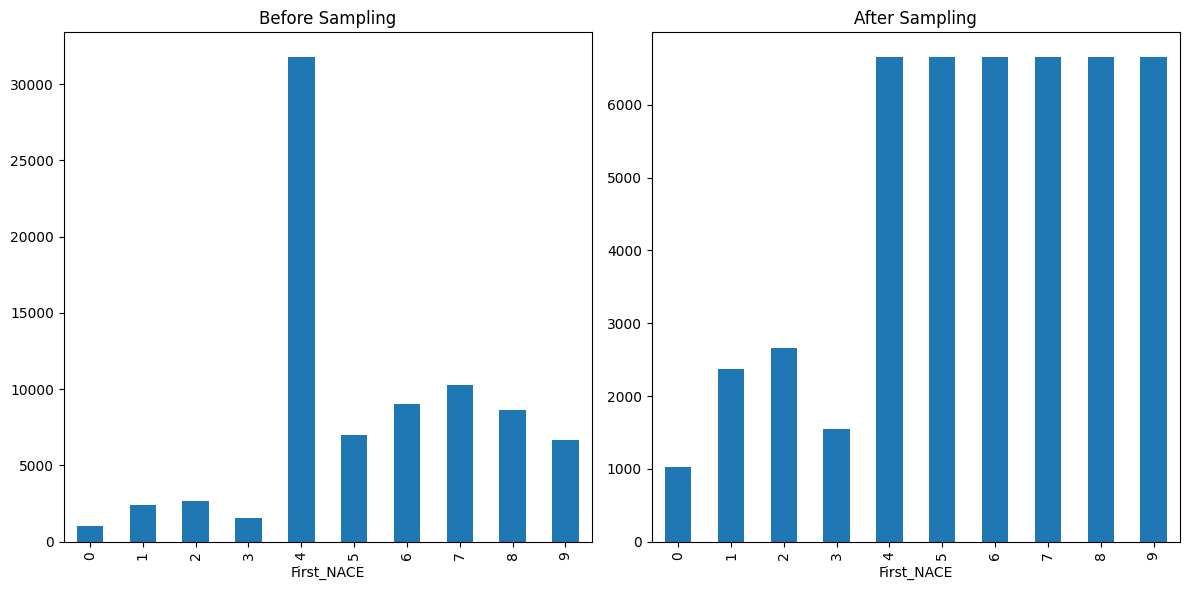

number of labels resampled: 871 - number of labels original 908 - number of instances deleted from these categories: 111
Training first digit model...
Number of samples for training: 38059
3644    3
672     4
186     8
2645    7
7842    6
       ..
4067    6
1636    5
6816    4
580     9
1848    4
Name: NACE, Length: 38059, dtype: object
First digit model trained and saved.
Training second digit model for first digit 0...
Number of samples for training: 810
Second digit model for first digit 0 trained and saved.
Training second digit model for first digit 1...
Number of samples for training: 1866
Second digit model for first digit 1 trained and saved.
Training second digit model for first digit 2...
Number of samples for training: 2142
Second digit model for first digit 2 trained and saved.
Training second digit model for first digit 3...
Number of samples for training: 1235
Second digit model for first digit 3 trained and saved.
Training second digit model for first digit 4...
Number 

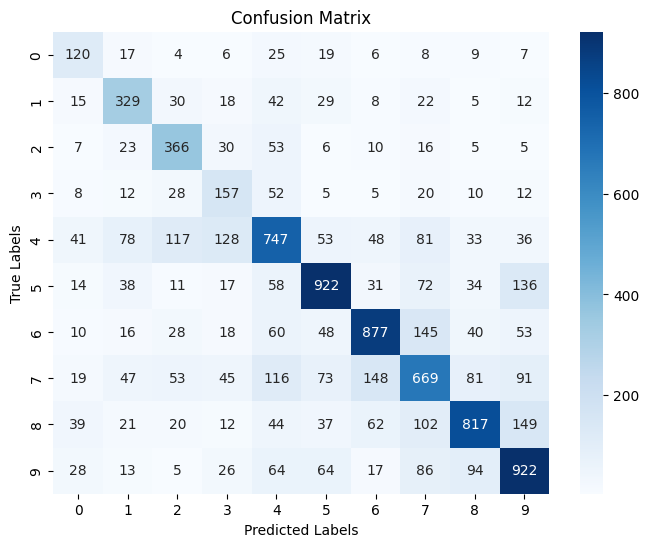

Accuracy (1 digit): 0.6228060956384656
Accuracy (2 digit): 0.5333683657383079
Accuracy (3 digit): 0.45832895428271153
Accuracy (4 digit): 0.40903836048344716
Overall Accuracy: 0.3738307934839727
Accuracy of 1 digit model: 0.6228060956384656
Accuracy of 2nd digit model: 0.5714135575407252
Accuracy of 3,4 and 5th digit model): 0.38003152916447713
F1 (1 digit): 0.6252513254622434
F1 (2 digit): 0.5261165394815012
F1 (3 digit): 0.4455972231190486
F1 (4 digit): 0.39221730586968623
Overall F1: 0.3563394588662294
F1 of 1 digit model: 0.6252513254622434
F1 of 2nd digit model: 0.5716555943391797
F1 of 3,4 and 5th digit model): 0.3745407693494171
Kendall tau (1 digit): 0.6087455465580577
Kendall tau (2 digit): 0.5866926879105029
Kendall tau (3 digit): 0.5824886306487028
Kendall tau (4 digit): 0.5795911678338287
Overall Kendall tau: 0.5778834288672473
Kendall tau of 1 digit model: 0.6087455465580577
Kendall tau of 2nd digit model: 0.4446711119215604
Kendall tau of 3,4 and 5th digit model): 0.36578

/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


running experiment according to settings: 2:inst:6660_TFIDF[50000]_CWEIGHT:True_DATA2
use_directory is 2
The selcted data directory is: /content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/AllData
/content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/AllData
loading data from /content/drive/MyDrive/Thesis/textdata_files/pre_processed_beta/AllData...
feature handling in progress. Downsampling: 6660, embeddings: False...
Total size of dataset before sampling: 79719
Number of instances before sampling:
First_NACE
4    31243
7    10077
6     8892
8     8526
5     6914
9     6585
2     2614
1     2332
3     1520
0     1015
X        1
Name: count, dtype: int64
6749.5
vectorizing using TF_IDF

Total size of dataset after sampling: 47366

Size of train set: 37892

Size of test set: 9474

Number of instances after sampling:
NACE
4    6660
5    6660
6    6660
7    6660
8    6660
9    6585
2    2614
1    2332
3    1520
0    1015
Name: count, dtype: int64


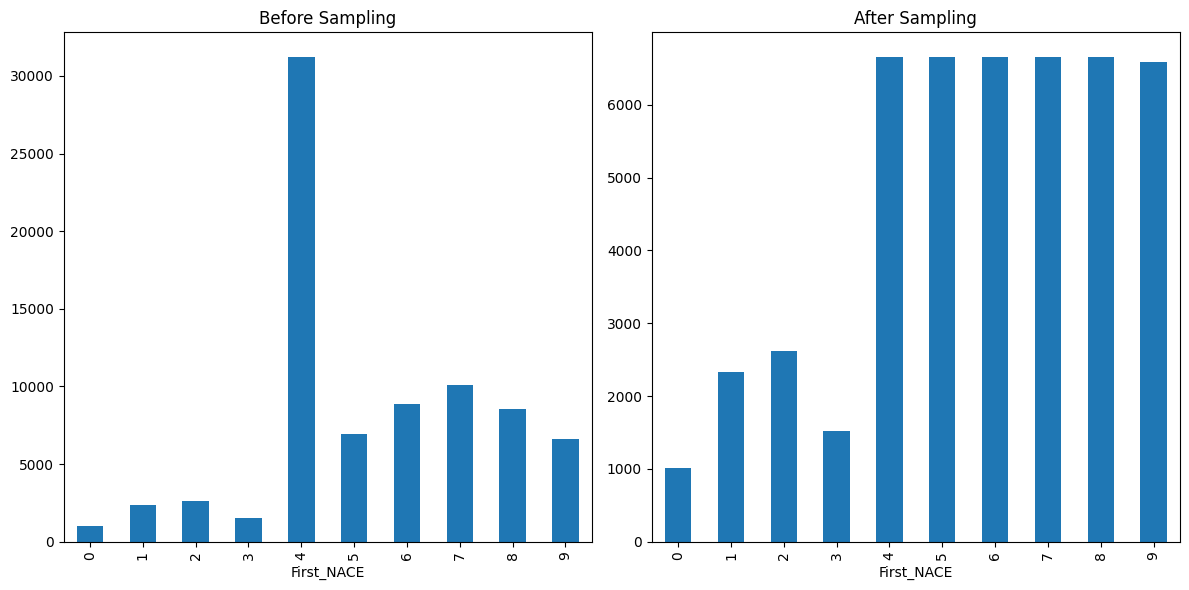

number of labels resampled: 876 - number of labels original 907 - number of instances deleted from these categories: 96
Training first digit model...
Number of samples for training: 37892
__null_dask_index__
50    3
32    8
50    9
15    1
51    7
     ..
89    6
82    5
26    4
77    9
12    4
Name: NACE, Length: 37892, dtype: object


KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    # All settings we want to test for raportation
    base_folder = '/content/drive/MyDrive/Thesis/models/Logistic_regression/models_test_code_final/'
    results_folder = '/content/drive/MyDrive/Thesis/models/Logistic_regression/results_test_code_final/'
    results_file = '/content/drive/MyDrive/Thesis/models/Logistic_regression/results_test_code_final/garbage.xlsx'
    # List where all experiment settings will be saved to pass to main function
    experiment_selections = list()
    # 6660 for downsampling data based on first number, 100000000 - no downsampling
    max_instances_options = [6660, 100000000] #6660 - 100000000
    random_state_values = [32] # keep
    tf_idf_max_features_options = [50000] # keep for all
    iterations_max_options = [1000] # all models converge long before 1000 iteration
    use_class_weighting_options = [True, False] # use class weighting?
    use_embeddings_options = [False, False] # use embeddings options
    pre_selected_use_directory_options = range(1, 10) # From which pre processed directory (pre made for faster processing during large scale testing)
    experiment_selections = [base_folder, results_folder, results_file, max_instances_options,
                             random_state_values, tf_idf_max_features_options, iterations_max_options,
                            use_class_weighting_options, use_embeddings_options, pre_selected_use_directory_options]
    main(experiment_selections)